In [1]:
import pickle
from pathlib import Path
import numpy as np
import statistics
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *

In [37]:
import pickle
from pathlib import Path
import numpy as np
import statistics

def convert_to_float(value):
    """Convert NumPy arrays or other numeric types to float or list of floats."""
    if isinstance(value, np.ndarray):
        return [float(f"{x:.13f}") for x in value]
    elif isinstance(value, (float, int, np.float32, np.float64, np.int32, np.int64)):
        return float(f"{value:.13f}")
    else:
        return value

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            # if trainable_params_dict == 'test20' or trainable_params_dict == 'test52':
            #     continue
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict

def get_jacobian(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    jacobian_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            #if trainable_params_dict == 'test14' or trainable_params_dict == 'test48':
             #   continue
            results = df[fixed_params_dict][trainable_params_dict]
            if 'jacobian' in results:
                jacobian = results['jacobian']
                if fixed_params_dict not in jacobian_dict:
                    jacobian_dict[fixed_params_dict] = {}
                jacobian_dict[fixed_params_dict][trainable_params_dict] = jacobian

    return jacobian_dict


def get_entropy(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    entropy_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            #if trainable_params_dict == 'test14' or trainable_params_dict == 'test48':
             #   continue
            results = df[fixed_params_dict][trainable_params_dict]
            
            if 'entropy' in results:
                entropy = results['entropy']
                # print(entropy)
                if fixed_params_dict not in entropy_dict:
                    entropy_dict[fixed_params_dict] = {}
                entropy_dict[fixed_params_dict][trainable_params_dict] = entropy

    return entropy_dict
def find_jacobian_variance_extremes(jacobian_dict):
    min_var_val = float('inf')
    max_var_val = float('-inf')

    min_var_params = None
    max_var_params = None

    for fixed_param, trainable_dict in jacobian_dict.items():
        for trainable_param, jacobian in trainable_dict.items():
            variance = np.var(jacobian)

            if variance < min_var_val:
                min_var_val = variance
                min_var_params = (fixed_param, trainable_param)

            if variance > max_var_val:
                max_var_val = variance
                max_var_params = (fixed_param, trainable_param)

    return {
        "min_jacobian_variance": (min_var_params, min_var_val),
        "max_jacobian_variance": (max_var_params, max_var_val)
    }
def find_extreme_params(qfim_eigvals_dict):
    min_trace_val = float('inf')
    max_trace_val = float('-inf')
    min_var_val = float('inf')
    max_var_val = float('-inf')

    min_trace_params = None
    max_trace_params = None
    min_var_params = None
    max_var_params = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            trace = np.sum(eigvals)
            variance = np.var(eigvals)

            if trace < min_trace_val:
                min_trace_val = trace
                min_trace_params = (fixed_param, trainable_param)

            if trace > max_trace_val:
                max_trace_val = trace
                max_trace_params = (fixed_param, trainable_param)

            if variance < min_var_val:
                min_var_val = variance
                min_var_params = (fixed_param, trainable_param)

            if variance > max_var_val:
                max_var_val = variance
                max_var_params = (fixed_param, trainable_param)

    return {
        "min_trace": (min_trace_params, min_trace_val),
        "max_trace": (max_trace_params, max_trace_val),
        "min_variance": (min_var_params, min_var_val),
        "max_variance": (max_var_params, max_var_val)
    }

def find_average_extreme_params(qfim_eigvals_dict):
    avg_trace_dict = {}
    avg_var_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        traces = [np.sum(eigvals) for eigvals in trainable_dict.values()]
        variances = [np.var(eigvals) for eigvals in trainable_dict.values()]

        avg_trace_dict[fixed_param] = np.mean(traces)
        avg_var_dict[fixed_param] = np.mean(variances)

    min_avg_trace_val = min(avg_trace_dict.values())
    max_avg_trace_val = max(avg_trace_dict.values())
    min_avg_var_val = min(avg_var_dict.values())
    max_avg_var_val = max(avg_var_dict.values())

    min_avg_trace_key = min(avg_trace_dict, key=avg_trace_dict.get)
    max_avg_trace_key = max(avg_trace_dict, key=avg_trace_dict.get)
    min_avg_var_key = min(avg_var_dict, key=avg_var_dict.get)
    max_avg_var_key = max(avg_var_dict, key=avg_var_dict.get)

    return {
        "avg_trace_dict": avg_trace_dict,
        "avg_var_dict": avg_var_dict,
        "min_avg_trace": (min_avg_trace_key, min_avg_trace_val),
        "max_avg_trace": (max_avg_trace_key, max_avg_trace_val),
        "min_avg_variance": (min_avg_var_key, min_avg_var_val),
        "max_avg_variance": (max_avg_var_key, max_avg_var_val)
    }

def find_range_extreme_params(qfim_eigvals_dict):
    trace_range_dict = {}
    var_range_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        traces = [np.sum(eigvals) for eigvals in trainable_dict.values()]
        variances = [np.var(eigvals) for eigvals in trainable_dict.values()]

        trace_range_dict[fixed_param] = max(traces) - min(traces)
        var_range_dict[fixed_param] = max(variances) - min(variances)

    min_trace_range_val = min(trace_range_dict.values())
    max_trace_range_val = max(trace_range_dict.values())
    min_var_range_val = min(var_range_dict.values())
    max_var_range_val = max(var_range_dict.values())

    min_trace_range_key = min(trace_range_dict, key=trace_range_dict.get)
    max_trace_range_key = max(trace_range_dict, key=trace_range_dict.get)
    min_var_range_key = min(var_range_dict, key=var_range_dict.get)
    max_var_range_key = max(var_range_dict, key=var_range_dict.get)

    return {
        "trace_range_dict": trace_range_dict,
        "var_range_dict": var_range_dict,
        "min_trace_range": (min_trace_range_key, min_trace_range_val),
        "max_trace_range": (max_trace_range_key, max_trace_range_val),
        "min_variance_range": (min_var_range_key, min_var_range_val),
        "max_variance_range": (max_var_range_key, max_var_range_val)
    }
def calculate_combined_score(avg_dict, range_dict, weight_avg=0.5, weight_range=0.5):
    """
    Calculate a combined score for each fixed parameter based on average and range values.
    The score is a weighted sum of normalized average and range values.
    """
    avg_values = list(avg_dict.values())
    range_values = list(range_dict.values())

    max_avg = max(avg_values)
    min_avg = min(avg_values)
    max_range = max(range_values)
    min_range = min(range_values)

    combined_scores = {}
    for key in avg_dict.keys():
        normalized_avg = (avg_dict[key] - min_avg) / (max_avg - min_avg)
        normalized_range = (range_dict[key] - min_range) / (max_range - min_range)
        combined_score = weight_avg * normalized_avg - weight_range * normalized_range
        combined_scores[key] = combined_score

    return combined_scores



# Example usage
N_ctrl = 2
Nr = 1
trotter_step = 8
sample = 'pi'
num_L = 100
state = 'GHZ'
kfactor = 1
base_path = f'/Users/sophieblock/QRCcapstone/parameter_analysis_directory/QFIM_results/gate/Nc_{N_ctrl}/sample_{sample}/{kfactor}xK/'
sample_range_label = '0.1'

file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / f'data.pickle'

# file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / f'data.pickle'




qfim_eigvals_dict = get_qfim_eigvals(file_path)
# print(qfim_eigvals_dict['fixed_params0']['test250'])
jacobian_dict = get_jacobian(file_path)
entropy_dict = get_entropy(file_path)

if qfim_eigvals_dict is not None:
    results = find_extreme_params(qfim_eigvals_dict)
    print(f"Minimum trace: {results['min_trace']}")
    print(f"Maximum trace: {results['max_trace']}")
    print(f"Minimum variance: {results['min_variance']}")
    print(f"Maximum variance: {results['max_variance']}")

    avg_results = find_average_extreme_params(qfim_eigvals_dict)
    print(f"Minimum average trace: {avg_results['min_avg_trace']}")
    print(f"Maximum average trace: {avg_results['max_avg_trace']}")
    print(f"Minimum average variance: {avg_results['min_avg_variance']}")
    print(f"Maximum average variance: {avg_results['max_avg_variance']}")

    range_results = find_range_extreme_params(qfim_eigvals_dict)
    print(f"Minimum trace range: {range_results['min_trace_range']}")
    print(f"Maximum trace range: {range_results['max_trace_range']}")
    print(f"Minimum variance range: {range_results['min_variance_range']}")
    print(f"Maximum variance range: {range_results['max_variance_range']}")

    combined_trace_scores = calculate_combined_score(avg_results['avg_trace_dict'], range_results['trace_range_dict'])
    combined_variance_scores = calculate_combined_score(avg_results['avg_var_dict'], range_results['var_range_dict'])

    best_trace_param = max(combined_trace_scores, key=combined_trace_scores.get)
    best_variance_param = max(combined_variance_scores, key=combined_variance_scores.get)

    print(f"\nBest fixed parameter for trace optimization: {best_trace_param}")
    print(f"Best fixed parameter for variance optimization: {best_variance_param}")

    best_trace_param_min = min(combined_trace_scores, key=combined_trace_scores.get)
    best_variance_param_min = min(combined_variance_scores, key=combined_variance_scores.get)

    print(f"\nBest fixed parameter for trace optimization: {best_trace_param_min}")
    print(f"Best fixed parameter for variance optimization: {best_variance_param_min}")
    jacobian_variance_extremes = find_jacobian_variance_extremes(jacobian_dict)
    print(f"Minimum Jacobian variance: {jacobian_variance_extremes['min_jacobian_variance']}")
    print(f"Maximum Jacobian variance: {jacobian_variance_extremes['max_jacobian_variance']}")

def find_fixed_param_with_smallest_max_trace(qfim_eigvals_dict):
    smallest_max_trace = float('inf')
    best_fixed_param = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        max_trace = float('-inf')
        for eigvals in trainable_dict.values():
            trace = np.sum(eigvals)
            if trace > max_trace:
                max_trace = trace
        
        if max_trace < smallest_max_trace:
            smallest_max_trace = max_trace
            best_fixed_param = fixed_param

    return best_fixed_param, smallest_max_trace
def find_fixed_param_with_largest_min_trace(qfim_eigvals_dict):
    largest_min_trace = float('-inf')
    best_fixed_param = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        min_trace = float('inf')
        for eigvals in trainable_dict.values():
            trace = np.sum(eigvals)
            if trace < min_trace:
                min_trace = trace
        
        if min_trace > largest_min_trace:
            largest_min_trace = min_trace
            best_fixed_param = fixed_param


    return best_fixed_param, largest_min_trace

if qfim_eigvals_dict is not None:
    best_fixed_param_largest_min, largest_min_trace = find_fixed_param_with_largest_min_trace(qfim_eigvals_dict)
    print(f"\n\nBest fixed parameter set with largest minimum trace: {best_fixed_param_largest_min}")
    print(f"Largest minimum trace: {largest_min_trace}")

    best_fixed_param_smallest_max, smallest_max_trace = find_fixed_param_with_smallest_max_trace(qfim_eigvals_dict)
    print(f"Best fixed parameter set with smallest maximum trace: {best_fixed_param_smallest_max}")
    print(f"Smallest maximum trace: {smallest_max_trace}")
#/Users/sophieblock/QRCCapstone/parameter_analysis_directory/QFIM_results/gate/Nc_2/sample_pi/1xK/Nr_1/trotter_step_10/data.pickle

Minimum trace: (('fixed_params0', 'test63'), Array(9.993011, dtype=float32))
Maximum trace: (('fixed_params0', 'test65'), Array(48.79341, dtype=float32))
Minimum variance: (('fixed_params0', 'test64'), Array(0.8495366, dtype=float32))
Maximum variance: (('fixed_params0', 'test16'), Array(55.740307, dtype=float32))
Minimum average trace: ('fixed_params0', 21.492104)
Maximum average trace: ('fixed_params0', 21.492104)
Minimum average variance: ('fixed_params0', 10.23116)
Maximum average variance: ('fixed_params0', 10.23116)
Minimum trace range: ('fixed_params0', Array(38.8004, dtype=float32))
Maximum trace range: ('fixed_params0', Array(38.8004, dtype=float32))
Minimum variance range: ('fixed_params0', Array(54.89077, dtype=float32))
Maximum variance range: ('fixed_params0', Array(54.89077, dtype=float32))

Best fixed parameter for trace optimization: fixed_params0
Best fixed parameter for variance optimization: fixed_params0

Best fixed parameter for trace optimization: fixed_params0
Be

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_36294/4235995978.py:228: RuntimeWarning: invalid value encountered in scalar divide
  normalized_avg = (avg_dict[key] - min_avg) / (max_avg - min_avg)


In [38]:
def process_qfim_eigvals(qfim_eigvals_dict, threshold=1e-12, alpha=0.75):
    # Create a new dictionary to store processed values
    processed_qfim_dict = {}

    for fixed_params, test_results in qfim_eigvals_dict.items():
        avg_eigvals = []
        
        # Iterate over tests and collect eigenvalues
        for test, eigvals in test_results.items():
            # Apply threshold and compute mean along eigenvalue axis
            eigvals = np.array(eigvals)
            avg_eigvals.append(np.where(eigvals < threshold, 0, eigvals))
        
        # Compute the mean of all tests' averaged eigenvalues
        avg_qfim_eigvals = np.mean(avg_eigvals, axis=0)
        avg_trace = sum(avg_qfim_eigvals)
        # Apply power scaling
        power_scaled_avg_qfim_eigvals = avg_qfim_eigvals ** alpha

        power_scaled_avg_qfim_eigvals_nonzero = np.array([val for val in avg_qfim_eigvals if val > threshold]) ** alpha

        

        # Save both the averaged and power-scaled values
        processed_qfim_dict[fixed_params] = {
            'avg_qfim_eigvals': avg_qfim_eigvals,
            'power_scaled_avg_qfim_eigvals': power_scaled_avg_qfim_eigvals,
            'power_scaled_avg_qfim_eigvals_nonzero': power_scaled_avg_qfim_eigvals_nonzero,
            'var_power_scaled_avg_qfim_eigvals': np.var(power_scaled_avg_qfim_eigvals),

            'var_power_scaled_avg_qfim_eigvals_nonzero': np.var(power_scaled_avg_qfim_eigvals_nonzero),
            'avg_trace':avg_trace

        }

    return processed_qfim_dict
print(len(qfim_eigvals_dict['fixed_params0'].values()))
# Process the eigenvalues
processed_qfim_dict = process_qfim_eigvals(qfim_eigvals_dict)

# Convert to DataFrame for visualization
df_all = pd.DataFrame(processed_qfim_dict)

# Display DataFrame
df_all

150


,fixed_params0
avg_qfim_eigvals,"[0.0, 0.0, 0.0, 0.0, 2.9373523e-06, 9.238478e-..."
power_scaled_avg_qfim_eigvals,"[0.0, 0.0, 0.0, 0.0, 7.095239e-05, 0.000167571..."
power_scaled_avg_qfim_eigvals_nonzero,"[7.095239e-05, 0.00016757156, 0.00040503306, 0..."
var_power_scaled_avg_qfim_eigvals,2.498013
var_power_scaled_avg_qfim_eigvals_nonzero,2.96431
avg_trace,21.492123


In [39]:
def get_average_variance_and_trace(qfim_eigvals_dict,entropy_dict, fixed_param):
    """
    This function takes in a dictionary of QFIM eigenvalues and a specific fixed_param key.
    It returns the average variance and trace for the given fixed_param.
    """
    if fixed_param not in qfim_eigvals_dict:
        print(f"Fixed parameter {fixed_param} not found in the data.")
        return None
    
    trainable_dict = qfim_eigvals_dict[fixed_param]
    # print(trainable_dict)
    traces = [np.sum(eigvals) for eigvals in trainable_dict.values()]
    variances = [np.var(eigvals) for eigvals in trainable_dict.values()]
    x = entropy_dict[fixed_param]
    # print(list(x.values()))
    entropies =  np.mean(list(x.values()))

    avg_trace = np.mean(traces)
    avg_variance = np.mean(variances)

    return {
        "avg_trace": avg_trace,
        "avg_variance": avg_variance,
        "avg_entropy":entropies,
    }

fps = [ "fixed_params0" ]
# fixed_param_key = "fixed_params1"  # Replace with the actual fixed_param key you're interested in

for fixed_param_key in qfim_eigvals_dict.keys():
    print(fixed_param_key)
    avg_results = get_average_variance_and_trace(qfim_eigvals_dict, entropy_dict,fixed_param_key)
    
    if avg_results:
        print(f"Average trace for fixed_param {fixed_param_key}: {avg_results['avg_trace']}")
        print(f"Average variance for fixed_param {fixed_param_key}: {avg_results['avg_variance']}")
        print(f"Average entropy for fixed_param {fixed_param_key}: {avg_results['avg_entropy']}\n")

fixed_params0
Average trace for fixed_param fixed_params0: 21.492103576660156
Average variance for fixed_param fixed_params0: 10.231160163879395
Average entropy for fixed_param fixed_params0: 0.5517850518226624



In [40]:
def get_metrics(fixed_param_key, test_key, jacobian_dict, qfim_eigvals_dict):
    """
    Calculate the variance of the Jacobian, variance of the QFIM eigenvalues, and trace of the QFIM eigenvalues
    for a given fixed_param_key and test_key.

    Args:
        fixed_param_key (str): The key for the fixed parameters.
        test_key (str): The key for the trainable parameters (test).
        jacobian_dict (dict): The dictionary containing the Jacobian values.
        qfim_eigvals_dict (dict): The dictionary containing the QFIM eigenvalues.

    Returns:
        dict: A dictionary with the calculated metrics (Jacobian variance, QFIM variance, QFIM trace), or None if not found.
    """
    metrics = {}

    # Calculate Jacobian variance
    if fixed_param_key in jacobian_dict:
        if test_key in jacobian_dict[fixed_param_key]:
            jacobian = jacobian_dict[fixed_param_key][test_key]
            jacobian_variance = np.var(jacobian)
            metrics['jacobian_variance'] = jacobian_variance
        else:
            print(f"Test key {test_key} not found in fixed parameter key {fixed_param_key}.")
            metrics['jacobian_variance'] = None
    else:
        print(f"Fixed parameter key {fixed_param_key} not found in Jacobian dictionary.")
        metrics['jacobian_variance'] = None

    # Calculate QFIM eigenvalues variance and trace
    if fixed_param_key in qfim_eigvals_dict:
        if test_key in qfim_eigvals_dict[fixed_param_key]:
            qfim_eigvals = qfim_eigvals_dict[fixed_param_key][test_key]
            qfim_variance = np.var(qfim_eigvals)
            qfim_trace = np.sum(qfim_eigvals)
            metrics['qfim_variance'] = qfim_variance
            metrics['qfim_trace'] = qfim_trace
        else:
            print(f"Test key {test_key} not found in fixed parameter key {fixed_param_key} for QFIM eigenvalues.")
            metrics['qfim_variance'] = None
            metrics['qfim_trace'] = None
    else:
        print(f"Fixed parameter key {fixed_param_key} not found in QFIM eigenvalues dictionary.")
        metrics['qfim_variance'] = None
        metrics['qfim_trace'] = None

    return metrics

# Example usage
fixed_param_key = 'fixed_params1'
test_keys = ['test65', 'test3', 'test49', 'test97', 'test0']

for test_key in test_keys:
    metrics = get_metrics(fixed_param_key, test_key, jacobian_dict, qfim_eigvals_dict)
    #print(metrics)
    if metrics['jacobian_variance'] is not None:
        print(f"\nMetrics for {fixed_param_key} and {test_key}:")
        print(f"  Variance of the Jacobian: {metrics['jacobian_variance']:.13f}")
        print(f"  Variance of the QFIM eigenvalues: {metrics['qfim_variance']:.13f}")
        print(f"  Trace of the QFIM eigenvalues: {metrics['qfim_trace']:.13f}")

Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.


In [41]:
threshold = 1e-14

def process_params(params):
    """Process a dictionary of parameters, converting all numeric values to floats or lists of floats."""
    #print(params)
    return {key: convert_to_float(value) for key, value in params.items()}
def convert_to_float(value):
    
    """Convert NumPy arrays or other numeric types to float or list of floats."""
    if isinstance(value, np.ndarray):
        # Convert NumPy array to list of floats
        return [float(f"{x:.13f}") for x in value]
    elif isinstance(value, (float, int, np.float32, np.float64, np.int32, np.int64)):
        # Convert single numeric value to float
        return float(f"{value:.13f}")
    else:
        # Return the value as-is if it's not a recognized numeric type
        return value
    
def convert_to_hashable(value):
    """Convert unhashable types (e.g., NumPy arrays) to hashable types (e.g., tuples)."""
    if isinstance(value, np.ndarray):
        return tuple(value.tolist())  # Convert arrays to tuples
    elif isinstance(value, list):
        return tuple(value)  # Convert lists to tuples
    else:
        return value

def process_params_for_hashing(params):
    """Process a dictionary of parameters, converting all values to hashable types."""
    return {key: convert_to_hashable(value) for key, value in params.items()}

some_results = {}


def find_max_variance_params(file_path,track):
    """
    Load data from a pickle file and find the parameters with the maximum mean variance of the qfim eigenvalues.

    Parameters:
    - file_path: Path object or str, the path to the pickle file.
    - metric: str, the metric to compare, e.g., 'mean_var_eigval' for mean variance of the qfim eigenvalues.

    Returns:
    Tuple of dictionaries for the fixed and trainable parameters with the maximum value of the specified metric.
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    min_trace = np.inf
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    max_result = -np.inf
    min_result = np.inf
    max_trace = -np.inf
    min_trace = np.inf
    max_trace_params = {}
    min_trace_params = {}
    max_trained_params = {}
    
    min_trained_params = {}
    max_fixed_params = None
    max_trained_params = {}
    min_fixed_params = None
    
    
    qfim_eigvals_dict = {}
    fixed_params_values_dict = {}
    
    for i, fixed_params_dict in enumerate(df.keys()):
        for test in df[fixed_params_dict].keys():
            #if  test == 'test13' or test == 'test14' or test == 'test11':
            #    continue
           # if test == 'test1' or test == 'test95':
            #    continue
            results = df[fixed_params_dict][test]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
                res = np.var(qfim_eigvals)
                trace = np.sum(nonzero_eigvals)
                #print(test,trace, min_trace)
                
                if trace < min_trace and fixed_params_dict == track:
                    min_trace = trace
                    
                    min_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    min_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in min_trainableparams]) + ']'
                    min_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    min_trace_params[fixed_params_dict] = {test:{"trace":trace,"params":min_trainableparams,
                                                                   "eigvals":min_trainableparams_eigvals}} 
                if trace > max_trace and fixed_params_dict == track:
                    max_trace = trace
                    
                    max_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    max_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in max_trainableparams]) + ']'
                    max_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    max_trace_params[fixed_params_dict] =  {test:{"trace":trace,"params":max_trainableparams,
                                                                   "eigvals":max_trainableparams_eigvals}} 
                if res < min_result and fixed_params_dict == track:
                    min_result = res
                    
                    min_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    min_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in min_trainableparams]) + ']'
                    min_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    min_trained_params[fixed_params_dict] = {test:{"var":res,"params":min_trainableparams,
                                                                   "eigvals":min_trainableparams_eigvals}} 
                if res > max_result and fixed_params_dict == track:
                    max_result = res
                    
                    max_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    max_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in max_trainableparams]) + ']'
                    max_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    max_trained_params[fixed_params_dict] =  {test:{"var":res,"params":max_trainableparams,
                                                                   "eigvals":max_trainableparams_eigvals}} 
                    
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = []
                
                qfim_eigvals_dict[fixed_params_dict].append(qfim_eigvals)
                if fixed_params_dict not in fixed_params_values_dict:
                    fixed_params_values_dict[fixed_params_dict] = {}
                
                fixed_params_values_dict[fixed_params_dict]['fixed_params'] = results.get('fixed_params', {})
        
    return qfim_eigvals_dict, fixed_params_values_dict,min_trace,max_result,max_trace_params,min_trace_params,max_trained_params,min_trained_params
param_set_key = 'fixed_params0'
qfim_eigvals_dict, fixed_params_values_dict,min_trace,max_trace,max_trace_params,min_trace_params,max_trained_params,min_trained_params = find_max_variance_params(file_path,param_set_key)



#print("\nFixed Parameters Values Dictionary:")
#for k, v in fixed_params_values_dict.items():
#    print(f"{k}: {v}")
print(min_trained_params)
print(max_trained_params)
print(min_trace_params)
print(max_trace_params)

# param_set_key = 'fixed_params1'
# qfim_eigvals_dict, fixed_params_values_dict,min_trace,max_trace,max_trace_params,min_trace_params,max_trained_params,min_trained_params = find_max_variance_params(file_path,param_set_key)
# print("\n",min_trained_params)
# print(max_trained_params)
# print(min_trace_params)
# print(max_trace_params)


{'fixed_params0': {'test64': {'var': Array(0.8495366, dtype=float32), 'params': '[0.6509360074996948, -2.7449223995208740, 2.6831464767456055, 2.8821070194244385, 2.8041250705718994, -2.9488813877105713, 2.7439677715301514, -2.3964953422546387, 2.3620383739471436, 1.4709846973419189, -0.3211119472980499, -1.0917541980743408, 2.4871053695678711, 1.2199639081954956, 2.6103932857513428, -2.0589056015014648, 2.2468795776367188, -1.0472623109817505, -2.7871870994567871]', 'eigvals': '[-0.0000000000000001, -0.0000000000000000, 0.0000000000000001, 0.0000000000000002, 0.0000010661866554, 0.0000141082618939, 0.0000160332983796, 0.0000485418713652, 0.0240799915045500, 0.1023818403482437, 0.1875125169754028, 0.3020788431167603, 0.3707925975322723, 0.5563213229179382, 0.7991768121719360, 1.0638241767883301, 1.6949903964996338, 2.3237340450286865, 3.4212954044342041]'}}}
{'fixed_params0': {'test16': {'var': Array(55.740307, dtype=float32), 'params': '[0.1091764196753502, 1.3807876110076904, -2.9654

In [28]:
import pickle
import numpy as np


from scipy.stats import median_abs_deviation
from ANALYSIS_SPECIFIC_CONFIG import is_valid_pickle_file,spread_per_sample_vectorized,spread_pooling_vectorized, load_and_clean_pickle, extract_Nr, extract_trotter_step
# # Example usage
# N_ctrl = 1
# Nr = 1
# trotter_step = 2
# state = 'GHZ'
# kfactor = 1
# base_path = f'/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/gate_model_theorem23_eigval_decomp/Nc_{N_ctrl}/{state}_state/1xK/'
import numpy as np

def compute_single_draw_stats(
    eigvals,
    threshold=1e-12,
    spread_methods=("variance", "mad"),
    ddof=1,
    scale="normal",
    # For Abbas dimension
    gamma=1.0,
    n=1,
    V_theta=1.0,
):
    """
    Compute QFIM (or DQFIM) statistics for a SINGLE set of eigenvalues (one draw).

    This function mirrors the fields from compute_all_stats for a single-draw scenario.


    """
    import numpy as np

    # Make sure it's an array
    if isinstance(eigvals, (list, tuple)):
        arr = np.array(eigvals, dtype=float)
    elif isinstance(eigvals, np.ndarray):
        arr = eigvals.astype(float)
    else:
        arr = np.array(eigvals, dtype=float)

    # Threshold small eigenvalues
    arr = np.where(arr < threshold, 0.0, arr)

    # --- 1) Basic stats ---
    draw_rank = np.count_nonzero(arr)
    var_all_eigenvalues = np.var(arr)
    # Nonzero subset
    nonzero = arr[arr > threshold]
    var_nonzero_eigenvalues = np.var(nonzero) if nonzero.size > 1 else 0.0
    trace_eigenvalues = np.sum(arr)

     # rank-normalized
    var_normalized_by_rank = var_all_eigenvalues / draw_rank
    trace_normalized_by_rank = trace_eigenvalues / draw_rank

    # --- 2) IPR-based dimension measures ---
    sum_eigs_sq = np.sum(arr**2)

    # raw
    if sum_eigs_sq > 0.0:
        ipr_deff_raw = (trace_eigenvalues**2) / sum_eigs_sq
    else:
        ipr_deff_raw = 0.0

    # shape (normalized)
    if trace_eigenvalues > 0.0:
        arr_norm = arr / trace_eigenvalues
        sum_norm_sq = np.sum(arr_norm**2)
        ipr_deff_norm = 1.0 / sum_norm_sq if sum_norm_sq > 0 else 0.0
    else:
        arr_norm = None
        ipr_deff_norm = 0.0

    # --- 3) Abbas-based dimension measures ---
    # alpha = gamma * n / (2 * log(n)) if n>1
    import math
    if n > 1 and math.log(n) != 0.0:
        alpha = (gamma * n) / (2.0 * math.log(n))
    else:
        alpha = 0.0

    # raw
    abbas_deff_raw = 0.0
    for lam in arr:
        val = 1.0 + alpha * lam
        if val <= 0.0:
            val = 1e-15
        abbas_deff_raw += np.log(val)
    # if V_theta != 1.0: abbas_deff_raw -= np.log(V_theta)  # optional

    # normalized
    if arr_norm is not None:
        abbas_deff_norm = 0.0
        for lam_n in arr_norm:
            val = 1.0 + alpha * lam_n
            if val <= 0.0:
                val = 1e-15
            abbas_deff_norm += np.log(val)
        # if V_theta != 1.0: abbas_deff_norm -= np.log(V_theta)
    else:
        abbas_deff_norm = 0.0


    # Create a 1-row 2D array for convenience
    arr_2d = arr.reshape(1, -1)
    spread_metrics = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(
            arr_2d,
            method=method,
            threshold=threshold,
            ddof=ddof,
            scale=scale
        )
        # there's exactly 1 value for a single row
        spread_metrics[f"spread_metric_{method}"] = per_draw[0] if per_draw.size > 0 else 0.0

    # --- 5) Build final dictionary ---
    stats_dict = {
        # Basic rank & absolute scale
        "draw_rank": draw_rank,
        "var_all_eigenvalues": var_all_eigenvalues,
        "var_nonzero_eigenvalues": var_nonzero_eigenvalues,
        "trace_eigenvalues": trace_eigenvalues,
        "var_normalized_by_rank": var_normalized_by_rank,
        "trace_normalized_by_rank": trace_normalized_by_rank,

        # IPR dimension
        "ipr_deff_raw": ipr_deff_raw,
        "ipr_deff_norm": ipr_deff_norm,

        # Abbas dimension
        "abbas_deff_raw": abbas_deff_raw,
        "abbas_deff_norm": abbas_deff_norm,
    }
    stats_dict.update(spread_metrics)

    return stats_dict
# file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / 'data.pickle'
file_path = '/Users/sophieblock/QRCCapstone/parameter_analysis_directory/QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1xK/Nr_1/trotter_step_14/L_100/data.pickle'

print(file_path)
with open(file_path, 'rb') as f:
    all_tests_data = pickle.load(f)
# Existing dictionaries
params_sorted_by_qfim_trace = {}
params_sorted_by_qfim_eigvals = {}
params_sorted_by_qfim_var,params_sorted_by_qfim_nonzero_var = {},{}
params_sorted_by_qfim_mineig = {}
params_sorted_by_qfim_entropy = {}
key_and_params = {}

# NEW dictionaries for IPR/Abbas or single-draw stats
params_sorted_by_ipr_raw = {}
params_sorted_by_ipr_norm = {}
params_sorted_by_abbas_raw = {}
params_sorted_by_abbas_norm = {}
params_sorted_rank = {}
params_sorted_spread_var, params_sorted_spread_mad = {}, {}
fixed_params_dict = 'fixed_params0'
test_data = all_tests_data[fixed_params_dict]

threshold = 1e-12
for trainable_params_dict in test_data.keys():
    results = test_data[trainable_params_dict]
    
    qfi_eigvals = results['qfim_eigvals']
    stats = compute_single_draw_stats(qfi_eigvals, threshold=threshold,
                                      gamma=1.0, n=100)   # or pick n=200, etc.

    # Now store them in your dictionaries
    rank = stats["draw_rank"]
    trace = stats["trace_eigenvalues"]
    variance = stats["var_all_eigenvalues"]
    variance_nonzero = stats["var_nonzero_eigenvalues"]
    ipr_raw = stats["ipr_deff_raw"]
    ipr_norm = stats["ipr_deff_norm"]
    abbas_raw = stats["abbas_deff_raw"]
    abbas_norm = stats["abbas_deff_norm"]
    spread_mad = stats["spread_metric_mad"]
    spread_var = stats["spread_metric_variance"]

    # existing:
    params_sorted_by_qfim_trace[trainable_params_dict] = float(trace)
    params_sorted_by_qfim_var[trainable_params_dict] = float(variance)
    params_sorted_by_qfim_nonzero_var[trainable_params_dict] = float(variance_nonzero)
    params_sorted_by_qfim_mineig[trainable_params_dict] = float(np.min(qfi_eigvals))
    params_sorted_spread_mad[trainable_params_dict] = spread_mad
    params_sorted_spread_var[trainable_params_dict] = spread_var
    # new ones:
    params_sorted_by_ipr_raw[trainable_params_dict] = ipr_raw
    params_sorted_by_ipr_norm[trainable_params_dict] = ipr_norm
    params_sorted_by_abbas_raw[trainable_params_dict] = abbas_raw
    params_sorted_by_abbas_norm[trainable_params_dict] = abbas_norm
    params_sorted_rank[trainable_params_dict] = rank

    # store these if you want:
    # key_and_params is unchanged
    key_and_params[trainable_params_dict] = results['trainable_params']
    
    try:
        ent = float(np.mean(results['entropies']))
    except KeyError:
        ent = float(results['entropy'])
    params_sorted_by_qfim_entropy[trainable_params_dict] = ent

# print(params_sorted_by_qfim_entropy)

# print(key_and_params.keys())
number_of_tests = len(test_data)

sorted_qfim_entropy = sorted(params_sorted_by_qfim_entropy.items(), key=lambda x: round(float(x[1]), 6))
sorted_qfim_var = sorted(params_sorted_by_qfim_var.items(), key=lambda x: float(x[1]))
sorted_qfim_var_nonzero = sorted(params_sorted_by_qfim_nonzero_var.items(), key=lambda x: float(x[1]))
sorted_qfim_trace = sorted(params_sorted_by_qfim_trace.items(), key=lambda x: float(x[1]))
# params_sorted_by_abbas_raw
sorted_qfim_abbas_d_eff = sorted(params_sorted_by_abbas_raw.items(), key=lambda x: float(x[1]))
# Calculate the number of parameters to select
number_of_tests = len(test_data)
sorted_qfim_spread_var = sorted(params_sorted_spread_var.items(), key=lambda x: float(x[1]))
# Convert arrays to scalars for sorting
#sorted_qfim_trace = sorted(params_sorted_by_qfim_trace.items(), key=lambda x: x[1].item() if isinstance(x[1], np.ndarray) else x[1])

print(f"sorted_qfim_trace: {sorted_qfim_trace}")
print(f"sorted_qfim_trace[::-1]: {sorted_qfim_trace[::-1]}\n")

print(f"sorted_qfim_var: {sorted_qfim_var}")
print(f"sorted_qfim_var[::-1]: {sorted_qfim_var[::-1]}\n")


print(f"sorted_qfim_spread_var: {sorted_qfim_spread_var}")
print(f"sorted_qfim_spread_var[::-1]: {sorted_qfim_spread_var[::-1]}\n")


print(f"sorted_qfim_abbas_d_eff: {sorted_qfim_abbas_d_eff}")
print(f"sorted_qfim_abbas_d_eff[::-1]: {sorted_qfim_abbas_d_eff[::-1]}\n")
# Calculate the number of parameters to select
num_to_select = len(sorted_qfim_trace) // 10

# Determine interval size
interval_size = len(sorted_qfim_trace) / num_to_select

# Select parameters based on intervals
selected_params = []
selected_params_with_vals = []

for i in range(num_to_select):
    start_idx = int(i * interval_size)
    end_idx = int((i + 1) * interval_size)
    interval = sorted_qfim_trace[start_idx:end_idx]
    midpoint = (interval[0][1] + interval[-1][1]) / 2
    closest_param = min(interval, key=lambda x: abs(x[1] - midpoint))
    selected_params.append(closest_param[0])
    selected_params_with_vals.append(closest_param)



print("Selected Parameters:", selected_params)
print("Selected Parameters with Values:", selected_params_with_vals)


smallest_key = sorted_qfim_trace[0][0]
print(f"min: {smallest_key} - var: {params_sorted_by_qfim_var[smallest_key]}, trace: {params_sorted_by_qfim_trace[smallest_key]}")
print(f"max: {sorted_qfim_trace[-1][0]} - var: {params_sorted_by_qfim_var[sorted_qfim_trace[-1][0]]}, trace: {params_sorted_by_qfim_trace[sorted_qfim_trace[-1][0]]}")

for i in range(1,4):
    key = sorted_qfim_trace[-i][0]


    if key not in selected_params:
        print(f"adding {key}...")
        selected_params.append(key)
        selected_params_with_vals.append((key,params_sorted_by_qfim_trace[key]))


for i in range(0,4):
    key = sorted_qfim_trace[i][0]


    if key not in selected_params:
        print(f"adding min {key}...")
        selected_params.append(key)
        selected_params_with_vals.append((key,params_sorted_by_qfim_trace[key]))


if smallest_key not in selected_params:
    selected_params.append(smallest_key)
    selected_params_with_vals.append((smallest_key,params_sorted_by_qfim_trace[smallest_key]))

print("Selected Parameters:", selected_params)


print("Selected Parameters with Values:", selected_params_with_vals)

/Users/sophieblock/QRCCapstone/parameter_analysis_directory/QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1xK/Nr_1/trotter_step_14/L_100/data.pickle
sorted_qfim_trace: [('test166', 1.794432385417167), ('test132', 2.006757045222912), ('test31', 2.5766901618917473), ('test152', 2.669225507590454), ('test106', 2.7709568144200603), ('test187', 2.7939458898836165), ('test53', 2.7973652786167804), ('test10', 2.8288792119565187), ('test16', 2.8575390038477053), ('test76', 2.984528982779011), ('test59', 3.023445612867363), ('test121', 3.092258397373371), ('test84', 3.1053000740357675), ('test109', 3.122165225475328), ('test189', 3.236153307312634), ('test182', 3.2425693158293143), ('test173', 3.3883090558229014), ('test18', 3.423509416403249), ('test102', 3.4280652895686217), ('test43', 3.4337832859018818), ('test134', 3.472598193504382), ('test113', 3.562853641109541), ('test99', 3.564462757552974), ('test91', 3.5953155246097594), ('test3', 3.7086388433235697), ('test95', 3.746946082566

In [31]:

for i in range(1,4):
    key = sorted_qfim_abbas_d_eff[-i][0]


    if key not in selected_params:
        print(f"adding {key}...")
        selected_params.append(key)
        selected_params_with_vals.append((key,params_sorted_by_abbas_raw[key]))



adding test137...
adding test130...
adding test79...


In [29]:
selected_param_set = set(selected_params)

for key in selected_params:
    print(key, params_sorted_spread_var[key])

test31 6.705209548521123
test189 6.767049432256444
test3 8.368366342228759
test111 7.604866630239961
test65 9.477439911083522
test52 11.284767008885286
test177 9.169319571601616
test24 10.249257386354618
test30 9.201765029800352
test28 7.084844107160499
test151 8.717092579069888
test80 8.026949497387749
test163 10.18342816955914
test21 8.66276024893619
test45 9.061297474663656
test69 7.576158538716476
test98 8.24272916066037
test49 9.282757238602136
test48 7.609713055998717
test181 9.816647938525366
test29 9.2618543184786
test8 9.849735040812467
test166 8.66766587327901
test132 5.070845978286395
test152 6.217503088290077


In [30]:
num_to_select = len(sorted_qfim_abbas_d_eff) // 10

# Determine interval size
interval_size = len(sorted_qfim_abbas_d_eff) / num_to_select

# Select parameters based on intervals
selected_params2 = []
selected_params_with_vals2 = []

for i in range(num_to_select):
    start_idx = int(i * interval_size)
    end_idx = int((i + 1) * interval_size)
    interval = sorted_qfim_abbas_d_eff[start_idx:end_idx]
    midpoint = (interval[0][1] + interval[-1][1]) / 2
    closest_param = min(interval, key=lambda x: abs(x[1] - midpoint))
    selected_params2.append(closest_param[0])
    selected_param_set.add(closest_param[0])
    selected_params_with_vals2.append(closest_param)



print("Selected Parameters:", selected_params2)
print("Selected Parameters with Values:", selected_params_with_vals2)
print(f"selected_param_set: {selected_param_set}")

Selected Parameters: ['test106', 'test6', 'test40', 'test71', 'test171', 'test136', 'test86', 'test110', 'test63', 'test48', 'test96', 'test0', 'test56', 'test36', 'test145', 'test158', 'test5', 'test157', 'test41', 'test130']
Selected Parameters with Values: [('test106', np.float64(8.300104294237608)), ('test6', np.float64(9.85496936519775)), ('test40', np.float64(10.222315654254093)), ('test71', np.float64(10.476589625227904)), ('test171', np.float64(10.666741652524749)), ('test136', np.float64(10.816586262938335)), ('test86', np.float64(10.965364445447165)), ('test110', np.float64(11.189344642203402)), ('test63', np.float64(11.35480350331223)), ('test48', np.float64(11.484367792725791)), ('test96', np.float64(11.623870943915554)), ('test0', np.float64(11.739500992603476)), ('test56', np.float64(11.895320611081342)), ('test36', np.float64(12.060934092741537)), ('test145', np.float64(12.2038788231107)), ('test158', np.float64(12.37794745511897)), ('test5', np.float64(12.51798865050248

In [21]:
to_add =['test19', 'test6', 'test22', 'test16', 'test67', 'test72', 'test52' ,'test38','test50', 'test46', 'test55','test79']
for key in to_add:
    selected_param_set.add(key)

In [23]:
print(selected_param_set)

{'test52', 'test96', 'test30', 'test79', 'test60', 'test37', 'test61', 'test98', 'test46', 'test5', 'test16', 'test20', 'test70', 'test22', 'test50', 'test12', 'test8', 'test6', 'test97', 'test78', 'test67', 'test53', 'test19', 'test56', 'test29', 'test75', 'test31', 'test71', 'test33', 'test26', 'test10', 'test72', 'test55', 'test38', 'test84', 'test74'}


In [18]:
# If you want to see the top 5 ipr_raw:
sorted_ipr_raw = sorted(params_sorted_by_ipr_raw.items(), key=lambda x: x[1])
print("lowest ipr raw keys:", sorted_ipr_raw[:5])
print("highest ipr raw keys:", sorted_ipr_raw[-5:])


# If you want to see the top 5 ipr_raw:
sorted_abbas_raw = sorted(params_sorted_by_abbas_norm.items(), key=lambda x: x[1])
print("lowest abbass raw keys:", sorted_abbas_raw[:5])
print("highest abbass raw keys:", sorted_abbas_raw[-5:])



# # If you want to see the top 5 ipr_raw:
# sorted_abbas_raw = sorted(params_sorted_by_abbas_raw.items(), key=lambda x: x[1])
# print("lowest abbass raw keys:", sorted_abbas_raw[:5])
# print("highest abbass raw keys:", sorted_abbas_raw[-5:])

lowest ipr raw keys: [('test29', np.float64(1.2801574761258205)), ('test48', np.float64(1.3030399397138899)), ('test8', np.float64(1.3608622531028596)), ('test66', np.float64(1.4124198638757608)), ('test78', np.float64(1.420183462929919))]
highest ipr raw keys: [('test60', np.float64(3.804062686718504)), ('test16', np.float64(3.8571536633453483)), ('test31', np.float64(3.9859005204144453)), ('test18', np.float64(4.196456444893122)), ('test47', np.float64(4.317053298250359))]
lowest abbass raw keys: [('test29', np.float64(3.4647368521011845)), ('test48', np.float64(3.508586463423478)), ('test8', np.float64(3.6674597973317)), ('test78', np.float64(3.7199639621756706)), ('test66', np.float64(3.8116038790664084))]
highest abbass raw keys: [('test43', np.float64(5.577490829763569)), ('test16', np.float64(5.585984946797747)), ('test47', np.float64(5.6349131471641245)), ('test18', np.float64(5.6878864327056)), ('test31', np.float64(5.709121762885129))]


In [ ]:

tests = ['test38','test6', 'test82', 'test79']
tests = ['test80', 'test69', 'test27', 'test91', 'test88', 'test92', 'test9', 'test56', 'test6', 'test85', 'test108', 'test15']
for test in tests:
    print(f"\n{test}:")
    
    print(f"Trace: {params_sorted_by_qfim_trace[test]}")
    print(f"Var: {params_sorted_by_qfim_var[test]}")
    print(f"Var (nonzero included): {params_sorted_by_qfim_nonzero_var[test]}")
    print(f"d_eff: {params_sorted_by_ipr_raw[test]:.2f}, d_eff 2: {params_sorted_by_abbas_raw[test]:.2f}, d_eff 3: {params_sorted_by_abbas_norm[test]:.2f}")

    # print(f"avg eig: {np.mean(params_sorted_by_qfim_eigvals[test]):.5e} +/- {np.std(params_sorted_by_qfim_eigvals[test]):.5e}")
    # print(f'\params: {len(key_and_params[test])}')
    


test80:
Trace: 2.0197061030048644
Var: 0.07162866217625818
Var (nonzero included): 0.08691283151213515
d_eff: 2.59, d_eff 2: 7.41, d_eff 3: 4.97

test69:
Trace: 2.1743576611261233
Var: 0.06622255721338628
Var (nonzero included): 0.07945820405999889
d_eff: 3.14, d_eff 2: 8.17, d_eff 3: 5.27

test27:
Trace: 2.372030715465371
Var: 0.06468469629642368
Var (nonzero included): 0.0766693594350151
d_eff: 3.69, d_eff 2: 8.61, d_eff 3: 5.37

test91:
Trace: 2.760967075060762
Var: 0.12560307322980763
Var (nonzero included): 0.15196465141079063
d_eff: 2.73, d_eff 2: 8.83, d_eff 3: 5.05

test88:
Trace: 2.7948016945665586
Var: 0.12377420157280336
Var (nonzero included): 0.14947219543132675
d_eff: 2.83, d_eff 2: 9.02, d_eff 3: 5.13

test92:
Trace: 4.391794456350908
Var: 0.3645776550162561
Var (nonzero included): 0.44375124391244186
d_eff: 2.43, d_eff 2: 9.35, d_eff 3: 4.49

test9:
Trace: 4.074498376883639
Var: 0.302056020518579
Var (nonzero included): 0.36707069076378834
d_eff: 2.51, d_eff 2: 9.63, d

In [10]:
key_and_params['test44']

Array([-2.8455856 , -3.0281658 ,  1.4368249 ,  2.8719838 , -1.2662406 ,
       -1.3654251 , -1.5355695 , -3.0276854 , -0.59824735, -1.3811064 ,
       -1.3715342 , -1.666047  , -1.23315   , -1.1459643 , -0.8573842 ,
       -1.9152919 ,  0.4559537 , -2.7501125 ,  3.1316552 ], dtype=float32)

In [8]:
key_and_params['test44']

Array([-2.8455856 , -3.0281658 ,  1.4368249 ,  2.8719838 , -1.2662406 ,
       -1.3654251 , -1.5355695 , -3.0276854 , -0.59824735, -1.3811064 ,
       -1.3715342 , -1.666047  , -1.23315   , -1.1459643 , -0.8573842 ,
       -1.9152919 ,  0.4559537 , -2.7501125 ,  3.1316552 ], dtype=float32)

In [29]:

['test97','test6', 'test82', 'test79']

['test97', 'test6', 'test82', 'test79']

In [15]:
def sort_top_reverse(sorted_A, sorted_B, sorted_entropy, top_n=10, entropy_threshold=float('inf'), trace_threshold=0.0, var_threshold=100000):
    """
    Sort the top N entries based on the magnitude of values in sorted_A (reverse).
    Filter results where the corresponding entropy is below the entropy_threshold
    and trace is above the trace_threshold.
    
    Args:
        sorted_A (dict): Dictionary to sort by (e.g., variance).
        sorted_B (dict): Dictionary used for secondary sorting (e.g., trace).
        sorted_entropy (dict): Dictionary with entropy values.
        top_n (int): Number of top entries to select.
        entropy_threshold (float): Maximum allowed entropy value for entries to be included.
        trace_threshold (float): Minimum allowed trace value for entries to be included.
    
    Returns:
        List of tuples containing sorted results based on sorted_A.
    """
    # Step 1: Sort the trace values by magnitude, smallest to largest
    sorted_by_trace_magnitude = sorted(sorted_A.items(), key=lambda x: abs(x[1]))
    
    # Step 2: Filter based on entropy and trace thresholds
    filtered_by_entropy_and_trace = [(param, value) for param, value in sorted_by_trace_magnitude
                                     if sorted_entropy[param] <= entropy_threshold and sorted_A[param] > trace_threshold]
    # Step 2: Filter based on entropy and trace thresholds
    filtered_by_variance = [(param, value) for param, value in filtered_by_entropy_and_trace
                                     if sorted_B[param] < var_threshold]
    
    # Step 3: Get the top N entries from the filtered results
    top_n_traces = filtered_by_variance[:]
    
    # Step 4: Sort the top N entries by their corresponding trace values in reverse
    sorted_top_n = sorted(top_n_traces, key=lambda x: sorted_entropy[x[0]])
    
    return sorted_top_n

# Example usage:
top_n_sorted_by_entropy_and_trace = sort_top_reverse(
    params_sorted_by_qfim_trace, 
    params_sorted_by_qfim_nonzero_var, 
    params_sorted_by_qfim_entropy, 
    top_n=100, 
    entropy_threshold=0.5,  # Specify your entropy threshold here
    trace_threshold=1.0    # Specify your trace threshold here
)

# Print results
print("\nTop 30 largest var values, sorted by trace (filtered by entropy and trace thresholds):")
for param, trace in top_n_sorted_by_entropy_and_trace:
    print(f"Parameter: {param}, Trace: {trace:2f}, Var: {params_sorted_by_qfim_nonzero_var[param]:4f}, Entropy: {params_sorted_by_qfim_entropy[param]:5f}")


Top 30 largest var values, sorted by trace (filtered by entropy and trace thresholds):
Parameter: test3, Trace: 3.708639, Var: 0.301851, Entropy: 0.364555
Parameter: test51, Trace: 6.867539, Var: 1.385666, Entropy: 0.415626
Parameter: test82, Trace: 5.753613, Var: 0.608795, Entropy: 0.422141
Parameter: test32, Trace: 5.334662, Var: 0.565278, Entropy: 0.434552
Parameter: test57, Trace: 3.854459, Var: 0.315639, Entropy: 0.435070
Parameter: test15, Trace: 5.352953, Var: 0.699005, Entropy: 0.438575
Parameter: test46, Trace: 7.680682, Var: 2.395735, Entropy: 0.442313
Parameter: test18, Trace: 3.423509, Var: 0.134105, Entropy: 0.447233
Parameter: test84, Trace: 3.105300, Var: 0.150798, Entropy: 0.448435
Parameter: test76, Trace: 2.984529, Var: 0.119336, Entropy: 0.450433
Parameter: test83, Trace: 5.881459, Var: 1.024528, Entropy: 0.451763
Parameter: test45, Trace: 8.077352, Var: 2.563736, Entropy: 0.451923
Parameter: test91, Trace: 3.595316, Var: 0.209987, Entropy: 0.452344
Parameter: test9

In [16]:
['test193', 'test137','test193', 'test137','test135','test118', 'test10']

['test193', 'test137', 'test193', 'test137', 'test135', 'test118', 'test10']

In [17]:
def sort_min_traces_by_entropy(sorted_A, sorted_B, sorted_entropy, top_n=10, entropy_threshold=0.0, trace_threshold=float('inf')):
    """
    Find the top N entries with the smallest trace values, filtering by minimum entropy and maximum trace thresholds.
    
    Args:
        sorted_A (dict): Dictionary to sort by (e.g., variance).
        sorted_B (dict): Dictionary with trace values.
        sorted_entropy (dict): Dictionary with entropy values.
        top_n (int): Number of top entries to select.
        entropy_threshold (float): Minimum allowed entropy value for entries to be included.
        trace_threshold (float): Maximum allowed trace value for entries to be included.
    
    Returns:
        List of tuples containing sorted results based on sorted_A.
    """
    # Step 1: Sort the trace values by magnitude, smallest to largest
    sorted_by_trace_magnitude = sorted(sorted_A.items(), key=lambda x: abs(x[1]))
    
    # Step 2: Filter based on the trace and entropy thresholds
    filtered_by_entropy_and_trace = [(param, value) for param, value in sorted_by_trace_magnitude
                                     if sorted_entropy[param] >= entropy_threshold and sorted_A[param] < trace_threshold]
    print(filtered_by_entropy_and_trace)
    # Step 3: Get the top N entries from the filtered results
    top_n_traces = filtered_by_entropy_and_trace[:]
    
    # Step 4: Sort the top N entries by their corresponding trace values in increasing order
    sorted_top_n = sorted(top_n_traces, key=lambda x: sorted_B[x[0]], reverse=True)
    
    return sorted_top_n

# Example usage:
top_n_sorted_by_min_trace_and_entropy = sort_min_traces_by_entropy(
    params_sorted_by_qfim_trace, 
    params_sorted_by_qfim_nonzero_var, 
    params_sorted_by_qfim_entropy, 
    top_n=100, 
    entropy_threshold=0.001,  # Specify your minimum entropy threshold here
    trace_threshold=1.5    # Specify your maximum trace threshold here
)

# Print results
print("\nTop 30 smallest var values, sorted by trace (filtered by minimum entropy and maximum trace thresholds):")
for param, trace in top_n_sorted_by_min_trace_and_entropy:
    print(f"Parameter: {param}, Trace: {trace:2f}, Var: {params_sorted_by_qfim_var[param]:4f}, Entropy: {params_sorted_by_qfim_entropy[param]:5f}")

KeyError: 'test6'

In [43]:
 
tests = ['test97','test6', 'test82', 'test79']
tests =  ['test0', 'test47','test46','test32', 'test2','test39','test27','test45','test84']
for test in tests:
    print(f"\n{test}:")
    
    print(f"Trace: {params_sorted_by_qfim_trace[test]}")
    print(f"Var: {params_sorted_by_qfim_var[test]}")
    print(f"Var (nonzero included): {params_sorted_by_qfim_nonzero_var[test]}")
    print(f"entropy: {params_sorted_by_qfim_entropy[test]}")
    print(f"avg eig: {np.mean(params_sorted_by_qfim_eigvals[test]):.5e} +/- {np.std(params_sorted_by_qfim_eigvals[test]):.5e}")
    print(f'\params: {len(key_and_params[test])}')
    


test0:
Trace: 21.33563232421875
Var: 7.1773295402526855
Var (nonzero included): 8.66535758972168
entropy: 0.44905731081962585
avg eig: 1.12293e+00 +/- 2.67905e+00
\params: 19

test47:
Trace: 28.088369369506836
Var: 14.60626220703125
Var (nonzero included): 17.7630615234375
entropy: 0.4924161434173584
avg eig: 1.47834e+00 +/- 3.82181e+00
\params: 19

test46:
Trace: 17.736217498779297
Var: 6.651515007019043
Var (nonzero included): 8.130914688110352
entropy: 0.5070755481719971
avg eig: 9.33485e-01 +/- 2.57905e+00
\params: 19

test32:
Trace: 21.263999938964844
Var: 7.0751423835754395
Var (nonzero included): 8.538774490356445
entropy: 0.42696624994277954
avg eig: 1.11916e+00 +/- 2.65991e+00
\params: 19

test2:
Trace: 17.156112670898438
Var: 3.0962774753570557
Var (nonzero included): 3.6465532779693604
entropy: 0.684136152267456
avg eig: 9.02953e-01 +/- 1.75962e+00
\params: 19

test39:
Trace: 22.727951049804688
Var: 13.073514938354492
Var (nonzero included): 16.076454162597656
entropy: 0.61

In [67]:
tests = ['test28','test58','test15','test26','test9']
tests =['test5', 'test107' ,'test127','test44']
tests =['test87','test192','test93','test139','test180','test39', 'test161','test162','test62','test101']
tests =['test18','test89','test73','test172','test35','test146','test196','test170' ,'test139','test15', 'test118','test82']
for test in tests:
    print(f"\n{test}:")
    
    print(f"Trace: {params_sorted_by_qfim_trace[test]}")
    print(f"Var: {params_sorted_by_qfim_var[test]}")
    print(f"Var (nonzero included): {params_sorted_by_qfim_nonzero_var[test]}")
    print(f"entropy: {params_sorted_by_qfim_entropy[test]}")
    print(f"avg eig: {np.mean(params_sorted_by_qfim_eigvals[test]):.5e} +/- {np.std(params_sorted_by_qfim_eigvals[test]):.5e}")
    print(f'\params: {len(key_and_params[test])}')
    


test18:
Trace: 30.0019588470459
Var: 28.042362213134766
Var (nonzero included): 48.698246002197266
entropy: 0.49393925070762634
avg eig: 1.11118e+00 +/- 5.29550e+00
\params: 27

test89:
Trace: 40.904972076416016
Var: 45.70011520385742
Var (nonzero included): 78.95508575439453
entropy: 0.4811582565307617
avg eig: 1.51500e+00 +/- 6.76019e+00
\params: 27

test73:
Trace: 0.8684285879135132
Var: 0.006157233379781246
Var (nonzero included): 0.009593304246664047
entropy: 0.05643397569656372
avg eig: 3.21640e-02 +/- 7.84680e-02
\params: 27

test172:
Trace: 1.3536624908447266
Var: 0.016760295256972313
Var (nonzero included): 0.026548974215984344
entropy: 0.18564411997795105
avg eig: 5.01356e-02 +/- 1.29462e-01
\params: 27

test35:
Trace: 1.0030364990234375
Var: 0.009047042578458786
Var (nonzero included): 0.01429735403507948
entropy: 0.08961037546396255
avg eig: 3.71495e-02 +/- 9.51159e-02
\params: 27

test146:
Trace: 1.6194825172424316
Var: 0.0359819121658802
Var (nonzero included): 0.0595867

In [24]:

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        for trainable_params_dict in df[fixed_params_dict].keys():
            
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict
def find_qfim_metrics_by_test(qfim_eigvals_dict, test_key, weight_mean=0.7, weight_range=0.3):
    """
    Find the trace and variance of the QFIM across all fixed parameter tests for a specific test key.

    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    - test_key: The specific test key to search for (e.g., 'test0').

    Returns:
    - Dictionary with trace and variance metrics.
    """
    trace_dict = {}
    variance_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        if test_key in trainable_dict:
            eigvals = trainable_dict[test_key]
            trace = np.sum(eigvals)
            variance = np.var(eigvals)
            trace_dict[fixed_param] = trace
            variance_dict[fixed_param] = variance

    mean_trace = np.mean(list(trace_dict.values()))
    mean_variance = np.mean(list(variance_dict.values()))
    range_trace = max(trace_dict.values()) - min(trace_dict.values())
    range_variance = max(variance_dict.values()) - min(variance_dict.values())

    weighted_avg_trace = weight_mean * mean_trace + weight_range * range_trace
    weighted_avg_variance = weight_mean * mean_variance + weight_range * range_variance

    return {
        "trace_dict": trace_dict,
        "variance_dict": variance_dict,
        "mean_trace": mean_trace,
        "mean_variance": mean_variance,
        "range_trace": range_trace,
        "range_variance": range_variance,
        "weighted_avg_trace": weighted_avg_trace,
        "weighted_avg_variance": weighted_avg_variance
    }



qfim_eigvals_dict = get_qfim_eigvals(file_path)
# Example usage
# Example usage
test_key = 'test116'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")
# Example usage
test_key = 'test33'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")

/Users/sophieblock/miniforge3/envs/Py_3_12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sophieblock/miniforge3/envs/Py_3_12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: max() iterable argument is empty

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_14622/3133365799.py:48: FutureWarning: The provided callable <function mean at 0x105cd3ba0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)


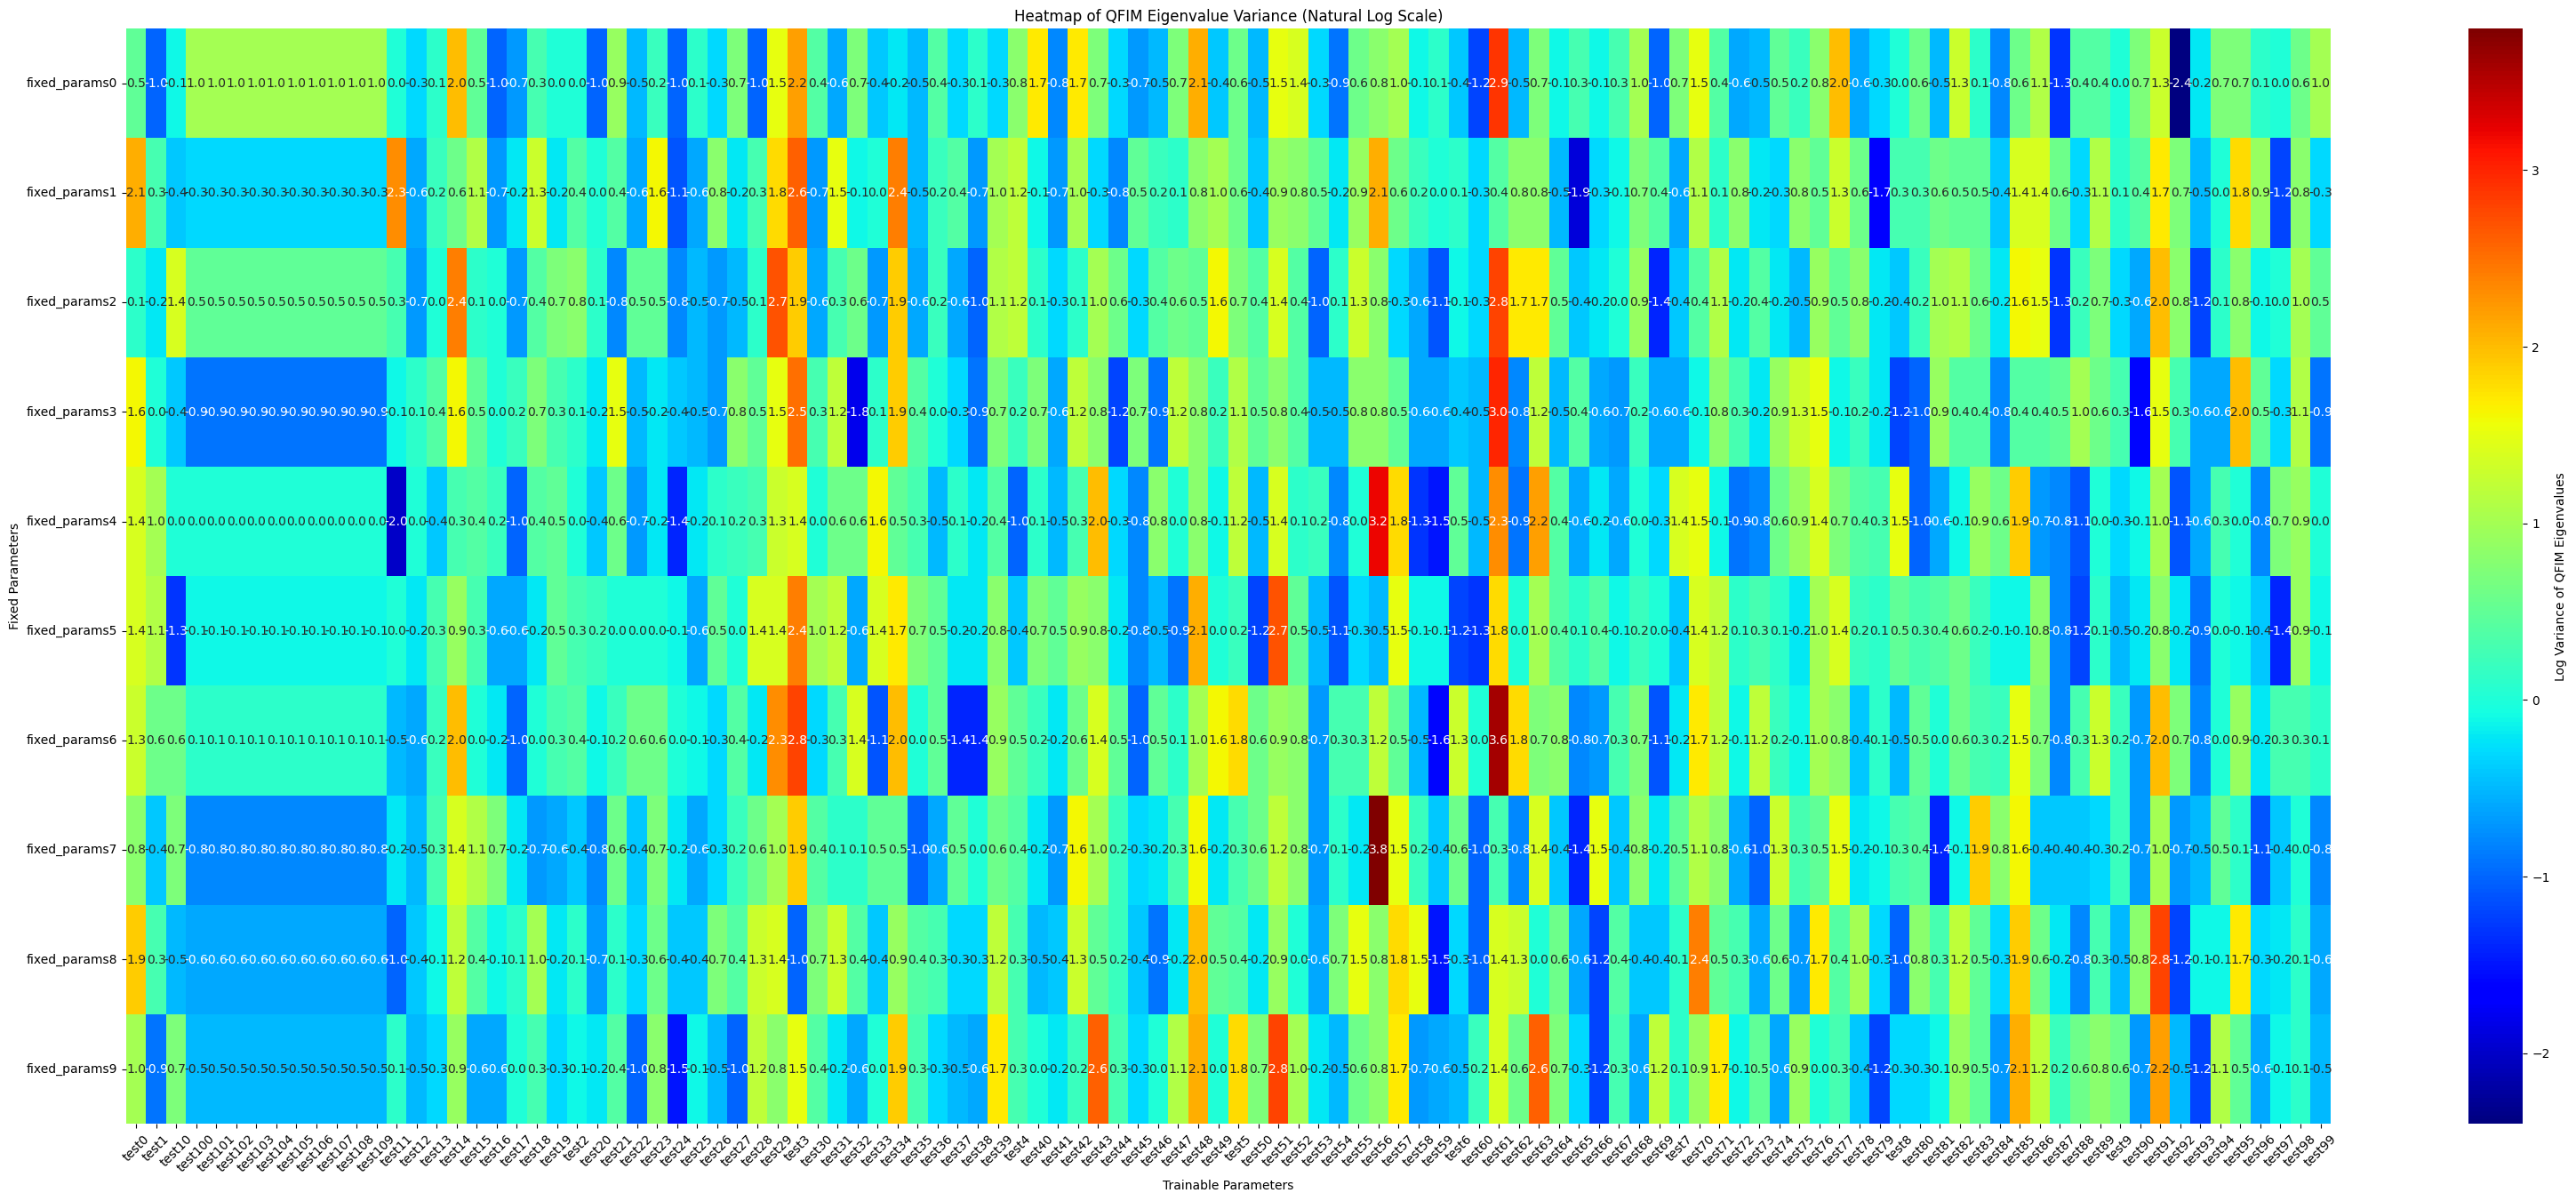

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_14622/3133365799.py:72: FutureWarning: The provided callable <function mean at 0x105cd3ba0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)


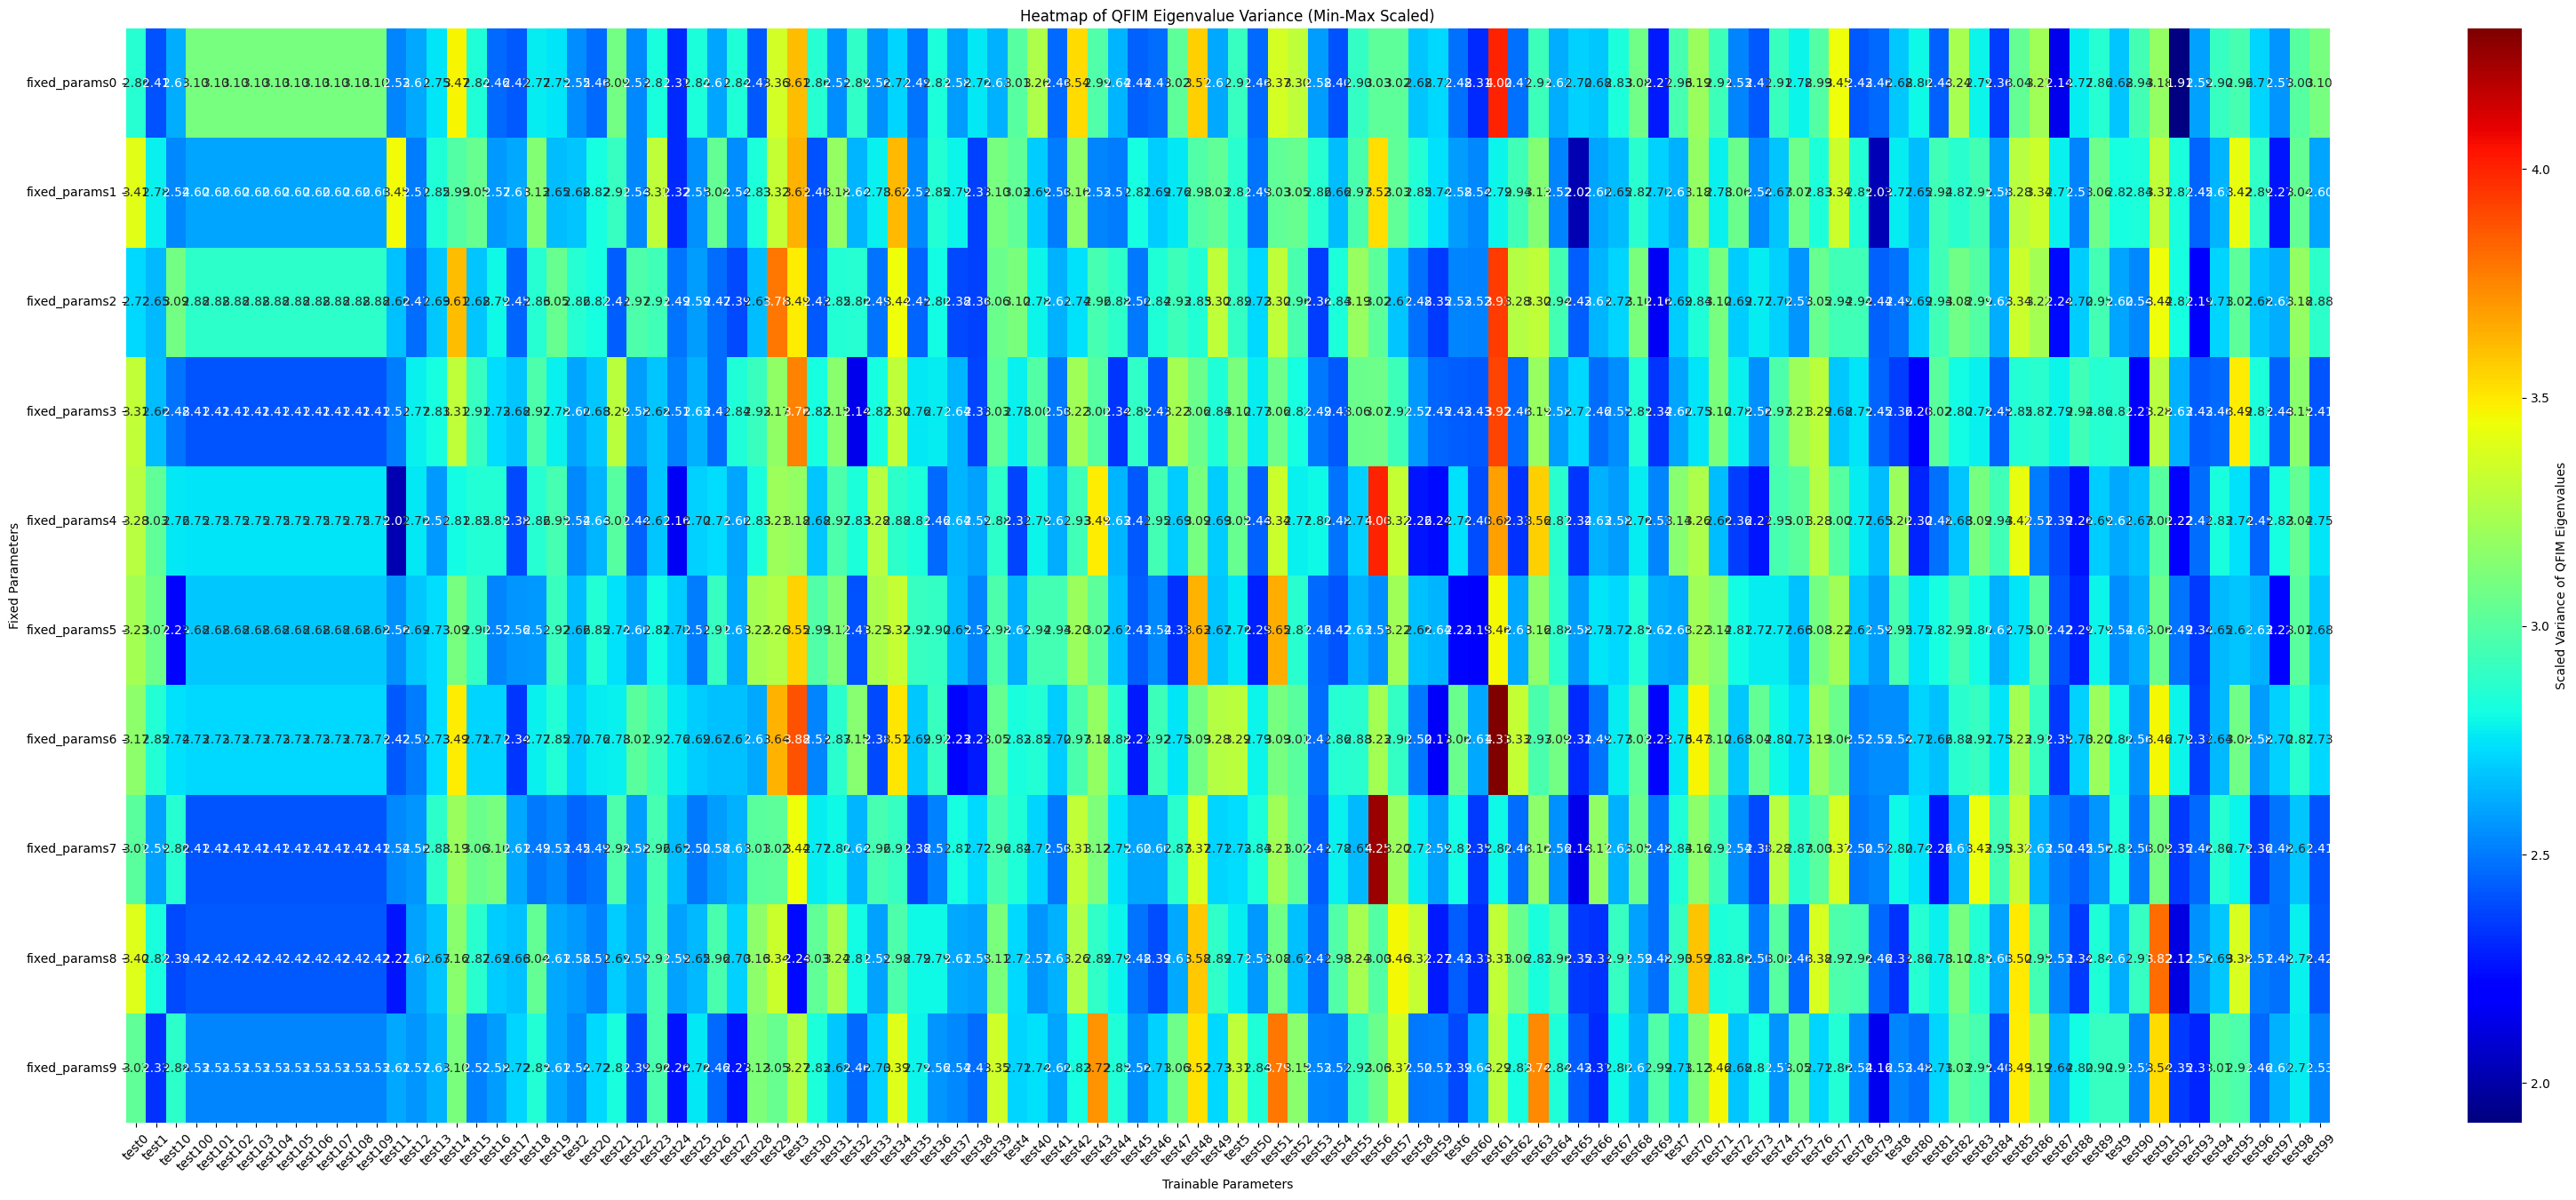

In [14]:
import seaborn as sns
def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            #if trainable_params_dict == 'test13' or trainable_params_dict == 'test14':
             #   continue
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict
def prepare_heatmap_data(qfim_eigvals_dict):
    """
    Prepare data for heatmap visualization.
    
    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    
    Returns:
    - DataFrame suitable for heatmap visualization.
    """
    heatmap_data = []
    
    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            variance = np.var(eigvals)
            if variance <= 0:
                variance = 1e-12  # Avoid log(0) by setting a small positive value
            log_variance = round(np.log(variance), 1)
            heatmap_data.append((fixed_param, trainable_param, log_variance))
    
    # Convert to DataFrame
    df_heatmap = pd.DataFrame(heatmap_data, columns=['Fixed Param', 'Trainable Param', 'Log Variance'])
    df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)
    
    return df_heatmap_pivot
def prepare_heatmap_data_trace(qfim_eigvals_dict):
    """
    Prepare data for heatmap visualization.
    
    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    
    Returns:
    - DataFrame suitable for heatmap visualization.
    """
    heatmap_data = []
    
    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            variance = np.sum(eigvals)
            
            log_variance = round(np.log(variance), 3)
            heatmap_data.append((fixed_param, trainable_param, log_variance))
    
    # Convert to DataFrame
    df_heatmap = pd.DataFrame(heatmap_data, columns=['Fixed Param', 'Trainable Param', 'Log Variance'])
    df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)
    
    return df_heatmap_pivot

def prepare_heatmap_data_minmax(qfim_eigvals_dict):
    heatmap_data = []
    variances = []

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            variance = np.var(eigvals)
            variances.append(variance)
            heatmap_data.append((fixed_param, trainable_param, variance))

    min_variance = min(variances)
    max_variance = max(variances)
    scaled_heatmap_data = [(fp, tp, (var - min_variance) / (max_variance - min_variance)) for fp, tp, var in heatmap_data]
    
    df_heatmap = pd.DataFrame(scaled_heatmap_data, columns=['Fixed Param', 'Trainable Param', 'Scaled Variance'])
    
    # Ensure all data is numeric
    df_heatmap['Scaled Variance'] = df_heatmap['Scaled Variance'].astype(float)
    
    df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Scaled Variance', aggfunc=np.mean)
    
    return df_heatmap_pivot


qfim_eigvals_dict = get_qfim_eigvals(file_path)
if qfim_eigvals_dict is not None:
    heatmap_data = prepare_heatmap_data(qfim_eigvals_dict)
    #print(heatmap_data.dtypes)
    # Create the heatmap
    plt.figure(figsize=(40, 16))  # Increase figsize for bigger cells
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='jet', cbar_kws={'label': 'Log Variance of QFIM Eigenvalues'})
    plt.title('Heatmap of QFIM Eigenvalue Variance (Natural Log Scale)')
    plt.xlabel('Trainable Parameters')
    plt.ylabel('Fixed Parameters')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

if qfim_eigvals_dict is not None:
    heatmap_data_minmax = prepare_heatmap_data_trace(qfim_eigvals_dict)
    
    
    # Create the heatmap
    plt.figure(figsize=(40, 16))  # Increase figsize for bigger cells
    sns.heatmap(heatmap_data_minmax, annot=True, fmt=".2f", cmap='jet', cbar_kws={'label': 'Scaled Variance of QFIM Eigenvalues'})
    plt.title('Heatmap of QFIM Eigenvalue Variance (Min-Max Scaled)')
    plt.xlabel('Trainable Parameters')
    plt.ylabel('Fixed Parameters')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [34]:

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        for trainable_params_dict in df[fixed_params_dict].keys():
            
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict
def find_qfim_metrics_by_test(qfim_eigvals_dict, test_key, weight_mean=0.7, weight_range=0.3):
    """
    Find the trace and variance of the QFIM across all fixed parameter tests for a specific test key.

    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    - test_key: The specific test key to search for (e.g., 'test0').

    Returns:
    - Dictionary with trace and variance metrics.
    """
    trace_dict = {}
    variance_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        if test_key in trainable_dict:
            eigvals = trainable_dict[test_key]
            trace = np.sum(eigvals)
            variance = np.var(eigvals)
            trace_dict[fixed_param] = trace
            variance_dict[fixed_param] = variance

    mean_trace = np.mean(list(trace_dict.values()))
    mean_variance = np.mean(list(variance_dict.values()))
    range_trace = max(trace_dict.values()) - min(trace_dict.values())
    range_variance = max(variance_dict.values()) - min(variance_dict.values())

    weighted_avg_trace = weight_mean * mean_trace + weight_range * range_trace
    weighted_avg_variance = weight_mean * mean_variance + weight_range * range_variance

    return {
        "trace_dict": trace_dict,
        "variance_dict": variance_dict,
        "mean_trace": mean_trace,
        "mean_variance": mean_variance,
        "range_trace": range_trace,
        "range_variance": range_variance,
        "weighted_avg_trace": weighted_avg_trace,
        "weighted_avg_variance": weighted_avg_variance
    }



qfim_eigvals_dict = get_qfim_eigvals(file_path)
# Example usage
# Example usage
test_key = 'test65'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")

Trace metrics for test65: {'fixed_params0': Array(14.922232, dtype=float32), 'fixed_params1': Array(7.5507975, dtype=float32), 'fixed_params2': Array(11.381183, dtype=float32), 'fixed_params3': Array(15.181354, dtype=float32), 'fixed_params4': Array(10.338419, dtype=float32), 'fixed_params5': Array(13.182128, dtype=float32), 'fixed_params6': Array(10.0645, dtype=float32), 'fixed_params7': Array(8.524782, dtype=float32), 'fixed_params8': Array(10.500038, dtype=float32), 'fixed_params9': Array(11.375399, dtype=float32)}
Variance metrics for test65: {'fixed_params0': Array(1.4045855, dtype=float32), 'fixed_params1': Array(0.14814086, dtype=float32), 'fixed_params2': Array(0.6599972, dtype=float32), 'fixed_params3': Array(1.5402452, dtype=float32), 'fixed_params4': Array(0.54815125, dtype=float32), 'fixed_params5': Array(1.1167301, dtype=float32), 'fixed_params6': Array(0.43212363, dtype=float32), 'fixed_params7': Array(0.25307137, dtype=float32), 'fixed_params8': Array(0.5339928, dtype=fl

In [18]:
test_key = 'test92'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")

Trace metrics for test92: {'fixed_params0': Array(6.771572, dtype=float32), 'fixed_params1': Array(16.828123, dtype=float32), 'fixed_params2': Array(16.753378, dtype=float32), 'fixed_params3': Array(13.8496, dtype=float32), 'fixed_params4': Array(9.207301, dtype=float32), 'fixed_params5': Array(12.017764, dtype=float32), 'fixed_params6': Array(16.29683, dtype=float32), 'fixed_params7': Array(10.435121, dtype=float32), 'fixed_params8': Array(8.366361, dtype=float32), 'fixed_params9': Array(10.485873, dtype=float32)}
Variance metrics for test92: {'fixed_params0': Array(0.09240144, dtype=float32), 'fixed_params1': Array(1.9980239, dtype=float32), 'fixed_params2': Array(2.1454182, dtype=float32), 'fixed_params3': Array(1.3178831, dtype=float32), 'fixed_params4': Array(0.32682627, dtype=float32), 'fixed_params5': Array(0.8169702, dtype=float32), 'fixed_params6': Array(1.9606341, dtype=float32), 'fixed_params7': Array(0.51811415, dtype=float32), 'fixed_params8': Array(0.31166345, dtype=float